In [89]:
!pip install tensorflow_addons

In [90]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *

In [91]:
df = pd.read_csv('TCS.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2003-01-01,59.987499,61.974998,59.987499,61.087502,45.255402,6027072.0
1,2003-01-02,61.525002,62.924999,57.912498,58.299999,43.190327,5325328.0
2,2003-01-03,60.000000,61.049999,58.500000,59.012501,43.718178,4198040.0
3,2003-01-06,59.924999,60.187500,56.875000,57.262501,42.421741,4121520.0
4,2003-01-07,58.000000,58.500000,56.062500,56.599998,41.930927,2650800.0


In [92]:
df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
df.dropna(inplace = True)
df.head()

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,Date,Open,High,Low,Close,Volume
0,2003-01-01,59.987499,61.974998,59.987499,61.087502,6027072.0
1,2003-01-02,61.525002,62.924999,57.912498,58.299999,5325328.0
2,2003-01-03,60.000000,61.049999,58.500000,59.012501,4198040.0
3,2003-01-06,59.924999,60.187500,56.875000,57.262501,4121520.0
4,2003-01-07,58.000000,58.500000,56.062500,56.599998,2650800.0


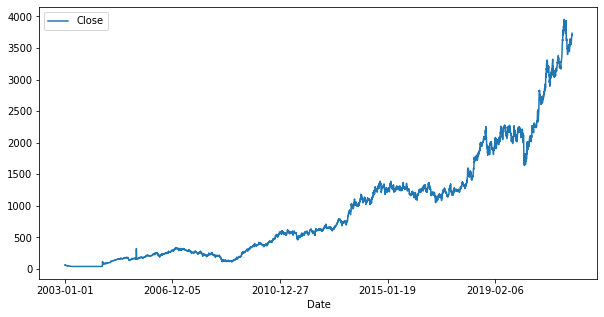

In [93]:
df.plot(x='Date', y='Close', kind='line', figsize=(10, 5))

In [94]:
dates = df.Date
df.drop(['Date'], inplace = True, axis = 1)
df.head()

,Open,High,Low,Close,Volume
0,59.987499,61.974998,59.987499,61.087502,6027072.0
1,61.525002,62.924999,57.912498,58.299999,5325328.0
2,60.000000,61.049999,58.500000,59.012501,4198040.0
3,59.924999,60.187500,56.875000,57.262501,4121520.0
4,58.000000,58.500000,56.062500,56.599998,2650800.0


In [95]:
scaler = MinMaxScaler(feature_range=(0,1))
data = scaler.fit_transform(df)

In [96]:
scaler2 = MinMaxScaler(feature_range=(0,1))
scaler2.fit_transform(df[['Close']])

array([[0.00579649],
       [0.0050847 ],
       [0.00526664],
       ...,
       [0.9366727 ],
       [0.93364675],
       [0.94361826]])

In [97]:
trainSize = int(len(data)*0.7)
testSize = len(data) - trainSize
train = data[0:trainSize]
test = data[trainSize:len(data)]

In [98]:
def modify(data, pastDays = 14):
  X = []
  Y = []
  for i in range(pastDays, len(data)):
      X.append(data[i - 14: i, 0: data.shape[1]])
      Y.append(data[i : i + 1, 3])
  return np.array(X), np.array(Y)

In [99]:
trainX, trainY = modify(train)
testX, testY = modify(test)

RNN

In [100]:
model1 = Sequential()
model1.add(InputLayer((trainX.shape[1], trainX.shape[2])))
model1.add(SimpleRNN(100))
model1.add(Dense(trainY.shape[1]))
model1.compile(optimizer='adam', loss='mse')
model1.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 100)               10600     
                                                                 
 dense_10 (Dense)            (None, 1)                 101       
                                                                 
Total params: 10,701
Trainable params: 10,701
Non-trainable params: 0
_________________________________________________________________


In [101]:
model1.fit(trainX, trainY, validation_data = (testX, testY), epochs = 5)

Epoch 1/5
103/103 [==============================] - 2s 12ms/step - loss: 6.8149e-04 - val_loss: 0.0034
Epoch 2/5
103/103 [==============================] - 1s 7ms/step - loss: 2.8277e-05 - val_loss: 0.0024
Epoch 3/5
103/103 [==============================] - 1s 6ms/step - loss: 2.3484e-05 - val_loss: 0.0019
Epoch 4/5
103/103 [==============================] - 1s 7ms/step - loss: 2.0733e-05 - val_loss: 0.0019
Epoch 5/5
103/103 [==============================] - 1s 7ms/step - loss: 2.5120e-05 - val_loss: 0.0023


In [102]:
trainPredict1 = model1.predict(trainX)
testPredict1 = model1.predict(testX)
trainPredict1 = scaler2.inverse_transform(trainPredict1)
testPredict1 = scaler2.inverse_transform(testPredict1)
trainY1 = scaler2.inverse_transform(trainY.reshape(-1, 1))
testY1 = scaler2.inverse_transform(testY.reshape(-1, 1))

In [103]:
mape1 = np.mean(np.abs((testY1 - testPredict1)/testY1))*100
mape1

4.664512321590881

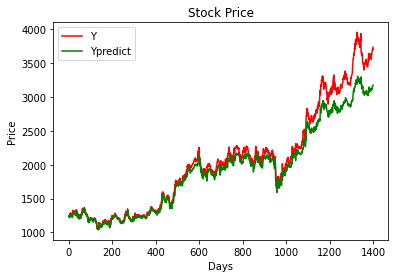

In [104]:
days = [i for i in range(0, len(testY1))]
plt.plot(days, testY1, color='r', label='Y')
plt.plot(days, testPredict1, color='g', label='Ypredict')  
plt.xlabel("Days")
plt.ylabel("Price")
plt.title("Stock Price")
plt.legend()
plt.show()

Classic LSTM

In [105]:
model2 = Sequential()
model2.add(InputLayer((trainX.shape[1], trainX.shape[2])))
model2.add(LSTM(200))
model2.add(Dense(trainY.shape[1]))
model2.compile(optimizer='adam', loss='mse')
model2.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 200)               164800    
                                                                 
 dense_11 (Dense)            (None, 1)                 201       
                                                                 
Total params: 165,001
Trainable params: 165,001
Non-trainable params: 0
_________________________________________________________________


In [106]:
model2.fit(trainX, trainY, validation_data = (testX, testY), epochs = 5)

Epoch 1/5
103/103 [==============================] - 8s 55ms/step - loss: 6.6699e-04 - val_loss: 3.0843e-04
Epoch 2/5
103/103 [==============================] - 6s 62ms/step - loss: 2.2321e-05 - val_loss: 4.7234e-04
Epoch 3/5
103/103 [==============================] - 7s 67ms/step - loss: 2.2305e-05 - val_loss: 3.6594e-04
Epoch 4/5
103/103 [==============================] - 7s 70ms/step - loss: 2.1753e-05 - val_loss: 3.6039e-04
Epoch 5/5
103/103 [==============================] - 7s 69ms/step - loss: 2.1493e-05 - val_loss: 3.2520e-04


In [107]:
trainPredict2 = model2.predict(trainX)
testPredict2 = model2.predict(testX)
trainPredict2 = scaler2.inverse_transform(trainPredict2)
testPredict2 = scaler2.inverse_transform(testPredict2)
trainY2 = scaler2.inverse_transform(trainY.reshape(-1, 1))
testY2 = scaler2.inverse_transform(testY.reshape(-1, 1))

In [108]:
mape2 = np.mean(np.abs((testY2 - testPredict2)/testY2))*100
mape2

2.2850690166511676

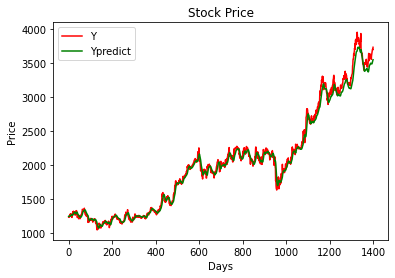

In [109]:
days = [i for i in range(0, len(testY2))]
plt.plot(days, testY2, color='r', label='Y')
plt.plot(days, testPredict2, color='g', label='Ypredict')
plt.xlabel("Days")
plt.ylabel("Price")
plt.title("Stock Price")
plt.legend()
plt.show()

LSTM Peephole

In [110]:
model3 = Sequential()
model3.add(InputLayer((trainX.shape[1], trainX.shape[2])))
model3.add(RNN(tfa.rnn.PeepholeLSTMCell(200)))
model3.add(Dense(trainY.shape[1]))
model3.compile(optimizer='adam', loss='mse')
model3.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rnn_1 (RNN)                 (None, 200)               165400    
                                                                 
 dense_12 (Dense)            (None, 1)                 201       
                                                                 
Total params: 165,601
Trainable params: 165,601
Non-trainable params: 0
_________________________________________________________________


In [111]:
model3.fit(trainX, trainY, validation_data = (testX, testY), epochs = 5)

Epoch 1/5
103/103 [==============================] - 6s 40ms/step - loss: 8.0609e-04 - val_loss: 3.4667e-04
Epoch 2/5
103/103 [==============================] - 4s 37ms/step - loss: 2.2947e-05 - val_loss: 6.5471e-04
Epoch 3/5
103/103 [==============================] - 4s 37ms/step - loss: 2.2643e-05 - val_loss: 5.3524e-04
Epoch 4/5
103/103 [==============================] - 4s 37ms/step - loss: 2.2614e-05 - val_loss: 7.1356e-04
Epoch 5/5
103/103 [==============================] - 4s 37ms/step - loss: 2.4735e-05 - val_loss: 6.1948e-04


In [112]:
trainPredict3 = model3.predict(trainX)
testPredict3 = model3.predict(testX)
trainPredict3 = scaler2.inverse_transform(trainPredict3)
testPredict3 = scaler2.inverse_transform(testPredict3)
trainY3 = scaler2.inverse_transform(trainY.reshape(-1, 1))
testY3 = scaler2.inverse_transform(testY.reshape(-1, 1))

In [113]:
mape3 = np.mean(np.abs((testY3 - testPredict3)/testY3))*100
mape3

3.1476437408481615

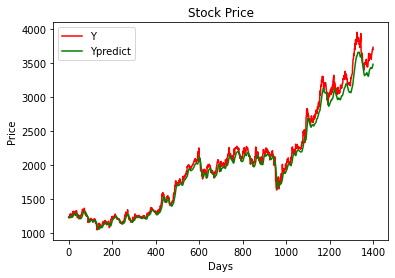

In [114]:
days = [i for i in range(0, len(testY3))]
plt.plot(days, testY3, color='r', label='Y')
plt.plot(days, testPredict3, color='g', label='Ypredict')
plt.xlabel("Days")
plt.ylabel("Price")
plt.title("Stock Price")
plt.legend()
plt.show()

Bidirectional LSTM

In [115]:
model4 = Sequential()
model4.add(InputLayer((trainX.shape[1], trainX.shape[2])))
model4.add(Bidirectional(LSTM(200)))
model4.add(Dense(trainY.shape[1]))
model4.compile(optimizer='adam', loss='mse')
model4.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirectio  (None, 400)              329600    
 nal)                                                            
                                                                 
 dense_13 (Dense)            (None, 1)                 401       
                                                                 
Total params: 330,001
Trainable params: 330,001
Non-trainable params: 0
_________________________________________________________________


In [116]:
model4.fit(trainX, trainY, validation_data = (testX, testY), epochs = 5)

Epoch 1/5
103/103 [==============================] - 11s 76ms/step - loss: 3.7518e-04 - val_loss: 7.2519e-04
Epoch 2/5
103/103 [==============================] - 8s 78ms/step - loss: 3.6929e-05 - val_loss: 5.0773e-04
Epoch 3/5
103/103 [==============================] - 6s 62ms/step - loss: 3.3699e-05 - val_loss: 8.7172e-04
Epoch 4/5
103/103 [==============================] - 6s 62ms/step - loss: 3.6221e-05 - val_loss: 6.5184e-04
Epoch 5/5
103/103 [==============================] - 6s 63ms/step - loss: 3.0656e-05 - val_loss: 6.6234e-04


In [117]:
trainPredict4 = model4.predict(trainX)
testPredict4 = model4.predict(testX)
trainPredict4 = scaler2.inverse_transform(trainPredict4)
testPredict4 = scaler2.inverse_transform(testPredict4)
trainY4 = scaler2.inverse_transform(trainY.reshape(-1, 1))
testY4 = scaler2.inverse_transform(testY.reshape(-1, 1))

In [118]:
mape4 = np.mean(np.abs((testY4 - testPredict4)/testY4))*100
mape4

3.140802546123512

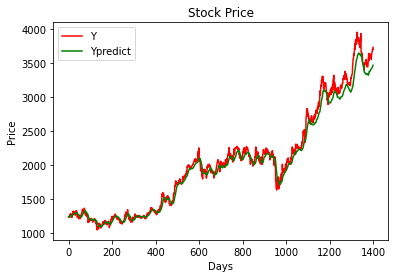

In [119]:
days = [i for i in range(0, len(testY4))]
plt.plot(days, testY4, color='r', label='Y')
plt.plot(days, testPredict4, color='g', label='Ypredict')
plt.xlabel("Days")
plt.ylabel("Price")
plt.title("Stock Price")
plt.legend()
plt.show()

GRU(Gated Recurrent Unit)

In [120]:
model5 = Sequential()
model5.add(InputLayer((trainX.shape[1], trainX.shape[2])))
model5.add(GRU(200))
model5.add(Dense(trainY.shape[1]))
model5.compile(optimizer='adam', loss='mse')
model5.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 200)               124200    
                                                                 
 dense_14 (Dense)            (None, 1)                 201       
                                                                 
Total params: 124,401
Trainable params: 124,401
Non-trainable params: 0
_________________________________________________________________


In [121]:
model5.fit(trainX, trainY, validation_data = (testX, testY), epochs = 5)

Epoch 1/5
103/103 [==============================] - 6s 37ms/step - loss: 5.5336e-04 - val_loss: 1.7266e-04
Epoch 2/5
103/103 [==============================] - 3s 32ms/step - loss: 1.5606e-05 - val_loss: 1.7620e-04
Epoch 3/5
103/103 [==============================] - 3s 31ms/step - loss: 1.5430e-05 - val_loss: 1.8907e-04
Epoch 4/5
103/103 [==============================] - 3s 31ms/step - loss: 1.4797e-05 - val_loss: 1.8584e-04
Epoch 5/5
103/103 [==============================] - 3s 32ms/step - loss: 1.4334e-05 - val_loss: 1.9547e-04


In [122]:
trainPredict5 = model5.predict(trainX)
testPredict5 = model5.predict(testX)
trainPredict5 = scaler2.inverse_transform(trainPredict5)
testPredict5 = scaler2.inverse_transform(testPredict5)
trainY5 = scaler2.inverse_transform(trainY.reshape(-1, 1))
testY5 = scaler2.inverse_transform(testY.reshape(-1, 1))

In [123]:
mape5 = np.mean(np.abs((testY5 - testPredict5)/testY5))*100
mape5

1.8049719382919942

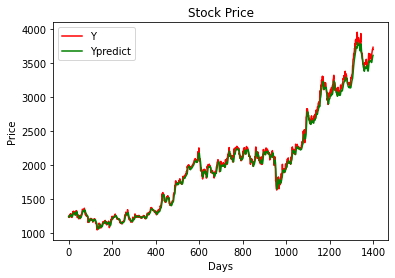

In [124]:
days = [i for i in range(0, len(testY5))]
plt.plot(days, testY5, color='r', label='Y')
plt.plot(days, testPredict5, color='g', label='Ypredict')
plt.xlabel("Days")
plt.ylabel("Price")
plt.title("Stock Price")
plt.legend()
plt.show()